# Question 2 assessment

### Imports & data loading


In [171]:
#importing libraries
import pandas as pd
import numpy as np
import os
from scipy import stats
from geopy.geocoders import Nominatim
import random
import networkx as nx
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from helper_functions import load_ratings, load_breweries, load_users, add_user_and_brewery_location, drop_breweries_with_less_than_n_reviews, get_average_rating_and_count_per_brewery, get_average_per_country, plot_world_map

In [3]:
#Dataset directories
ROOT_DIR = os.path.abspath(os.curdir)
DATA_DIR = os.path.join(ROOT_DIR, 'data/')
BA_DIR = os.path.join(DATA_DIR, 'BeerAdvocate/')
RB_DIR = os.path.join(DATA_DIR, 'RateBeer/')
MATCHED_BEER_DIR = os.path.join(DATA_DIR, "matched_beer_data/")

In [4]:
#Dataset loading
ratings_data = load_ratings(os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_rb.txt'), os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_ba.txt'))
breweries_data = load_breweries(os.path.join(RB_DIR, 'breweries.csv'), os.path.join(BA_DIR, 'breweries.csv'))
users_data = load_users(os.path.join(RB_DIR, 'users.csv'), os.path.join(BA_DIR, 'users.csv'))

In [172]:
#ratings_data

In [174]:
#breweries_data

In [173]:
#users_data

In [54]:
def add_user_and_brewery_locations(ratings, users, breweries):
    # Create dictionaries for user and brewery locations
    users_location_dict = {user_id: location for user_id, location in zip(users['user_id'], users['location'])}
    breweries_location_dict = {brewery_id: location for brewery_id, location in zip(breweries['id'], breweries['location'])}

    # Make a copy of the ratings dataframe
    ratings_final = ratings.copy()

    # Convert user_id and brewery_id to strings
    ratings_final['user_id'] = ratings_final['user_id'].astype(str)
    ratings_final['brewery_id'] = ratings_final['brewery_id'].astype(str)

    # Map brewery and user locations to the ratings dataframe
    ratings_final['brewery_location'] = ratings_final['brewery_id'].map(breweries_location_dict)
    ratings_final['user_location'] = ratings_final['user_id'].map(users_location_dict)

    # Split ratings into local and international based on location
    ratings_local = ratings_final[ratings_final['brewery_location'] == ratings_final['user_location']]
    ratings_international = ratings_final[ratings_final['brewery_location'] != ratings_final['user_location']]

    return ratings_final, ratings_local, ratings_international


# From which countries do the majority of ratings for each nation's beers originate?

## Preprocessing

In [58]:
#Calling auxilliary function to generate overall ratings, local_ratings, international_ratings dataframes.
ratings, local_ratings, international_ratings = add_user_and_brewery_locatio(ratings_data, users_data, breweries_data)

In [185]:
#ratings

In [186]:
#local_ratings

In [187]:
#international_ratings

By looking at the data, we notice missing information about the user's locations, this is understandable as I myself would not freely give out this information on an online forum, to proceed, we will need to handle these missing values.

In [101]:
# Combining ratings from different sources
combined_ratings = pd.concat([local_ratings, international_ratings])

# Counting ratings by user and brewery location
rating_sources = combined_ratings.groupby(['brewery_location', 'user_location']).size().reset_index(name='rating_count')

# Filtering out unspecified user locations ('nan')
rating_sources_filtered = rating_sources[rating_sources['user_location'] != 'nan']

# Sorting and summarizing ratings per brewery's country
rating_counts_per_brewery_country = rating_sources_filtered.groupby('brewery_location').sum().reset_index().sort_values(by='rating_count', ascending=False)

# Picking the top 10 brewery countries with the most ratings
top_10_brewery_countries = rating_counts_per_brewery_country.head(10)['brewery_location']

# Narrowing it down to those top 10 countries
top_10_rating_sources = rating_sources_filtered[rating_sources_filtered['brewery_location'].isin(top_10_brewery_countries)]

# Finding the major sources of ratings for each of the top 10 countries
top_10_sources_analysis = top_10_rating_sources.sort_values(['brewery_location', 'rating_count'], ascending=[True, False])
top_10_sources_per_brewery = top_10_sources_analysis.groupby('brewery_location').head(3)

top_10_sources_per_brewery  # Checking out the results

,brewery_location,user_location,rating_count
293,Belgium,United States,51241
208,Belgium,Belgium,11702
224,Belgium,Denmark,10349
448,Canada,Canada,46059
507,Canada,United States,14751
455,Canada,Denmark,629
769,Denmark,Denmark,14690
812,Denmark,Sweden,4175
819,Denmark,United States,3968
1227,Germany,United States,25819


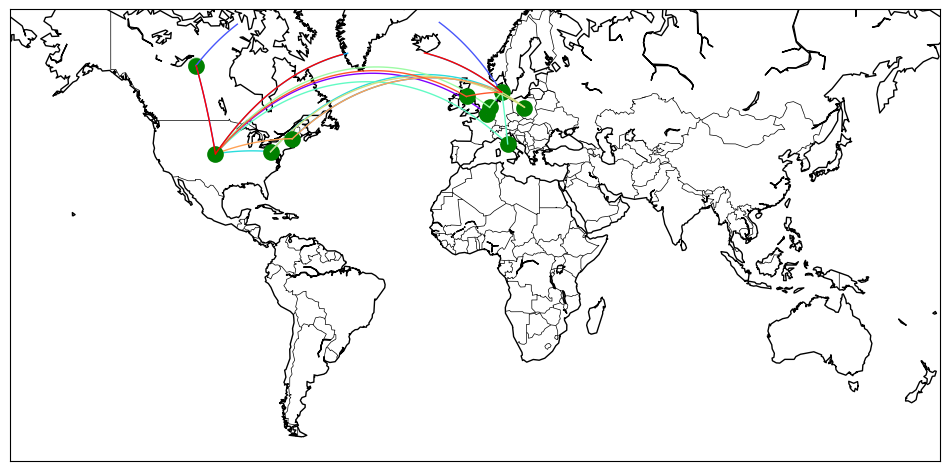

In [52]:
# Combining location data with maps
geolocator = Nominatim(user_agent="geoapiExercises")

# Adding randomness to latitudes and longitudes
def get_lat_lon(location, offset=0.05):
    try:
        loc = geolocator.geocode(location)
        lat = loc.latitude + random.uniform(-offset, offset)
        lon = loc.longitude + random.uniform(-offset, offset)
        return (lat, lon)
    except:
        return (None, None)

def draw_map(dataframe):
    # Creating a large map
    plt.figure(figsize=(12, 8))
    m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

    # Drawing coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Picking colors for breweries
    brewery_locations = dataframe['brewery_location'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(brewery_locations)))

    # Looping through data
    for index, row in dataframe.iterrows():
        brewery_loc = row['brewery_location']
        user_loc = row['user_location']
        rating_count = row['rating_count']

        lat_brewery, lon_brewery = get_lat_lon(brewery_loc)
        lat_user, lon_user = get_lat_lon(user_loc)

        if lat_brewery and lon_brewery and lat_user and lon_user:
            x_brewery, y_brewery = m(lon_brewery, lat_brewery)
            x_user, y_user = m(lon_user, lat_user)

            # Adjusting arrow width based on ratings
            arrow_width = np.clip(1 / 10000, 1, 5)

            # Plotting a green circle for same-location brews
            if brewery_loc == user_loc:
                m.plot(x_brewery, y_brewery, 'o', markersize=10, color='green', markeredgewidth=2)
                m.tissot(lon_brewery, lat_brewery, 1.5, 100, facecolor='green', alpha=0.4)
            else:
                # Matching colors to brewery locations
                color = colors[np.where(brewery_locations == brewery_loc)[0][0]]

                # Drawing arrows from brewery to user
                m.drawgreatcircle(lon_brewery, lat_brewery, lon_user, lat_user, linewidth=arrow_width, color=color)

    # Displaying the map without a legend
    plt.show()

# Visualizing our map
draw_map(top_10_sources_per_brewery)


# Which country’s beers are particularly popular abroad?

First we take a look at the countries with the highest number of reviews and we compare that with countries with the highest number of reviews from abroad and see if there are any proportinal differences

In [108]:
# Group by brewery location and user location, then count the ratings
rating_sources_international = international_ratings.groupby(['brewery_location', 'user_location']).size().reset_index(name='rating_count')

# Filter out rows where 'user_location' is not the string 'nan'
rating_sources_filtered_international = rating_sources_international[rating_sources_international['user_location'] != 'nan']

# Sort and count ratings for each brewery country
rating_counts_per_brewery_country_international = rating_sources_filtered_international.groupby('brewery_location').sum().reset_index().sort_values(by='rating_count', ascending=False)

most_reviewed_countries_international = rating_counts_per_brewery_country_international.drop(columns=['user_location'])
most_reviewed_countries_international.head(10)

,brewery_location,rating_count
10,Belgium,116013
136,United States,90299
135,United Kingdom,69363
43,Germany,59965
31,Denmark,26968
59,Italy,22096
90,Netherlands,21398
121,Sweden,21390
19,Canada,20989
40,France,13162


In [117]:
# Prepare data by removing 'user_location' for focus
most_reviewed_countries = rating_counts_per_brewery_country.drop(columns=['user_location'])

# Merge two DataFrames using 'brewery_location'
merged_df = pd.merge(
    most_reviewed_countries_international,
    most_reviewed_countries,
    on='brewery_location',
    suffixes=('_international', '_total')
)

# Calculate international review proportion
merged_df['proportion_international'] = merged_df['rating_count_international'] / merged_df['rating_count_total']

# Keep only brewery location and international proportion
merged_df = merged_df[['brewery_location', 'proportion_international']]

# Present the top 10 with the highest international proportions
merged_df.head(10).sort_values(by='proportion_international', ascending=False)


,brewery_location,proportion_international
9,France,0.912064
0,Belgium,0.908374
5,Italy,0.858831
3,Germany,0.819586
2,United Kingdom,0.682532
4,Denmark,0.647367
6,Netherlands,0.620016
7,Sweden,0.536978
8,Canada,0.313044
1,United States,0.160370


It appears that the none english speaking countries in general have a higher proportion of international beer reviews. This makes sense because the beer review dataset is made up of english reviews, so you would expect a high proportion of the reviews to originate from the United States, Canada and the United Kingdom, and indeed, despite the united states having significantly higher international rating counts than most countries besides belgium, the proportion of international beer reviews is the lowest of the bunch, this affirms that a high proportion of beer reviews originate from the United States. 

In [91]:
# Calculate average rating and count per brewery
def get_average_rating_and_count_per_brewery(ratings):
    # Convert 'rating' to numeric, handling non-numeric values
    ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')

    # Calculate mean and count for each brewery
    ratings_by_brewery = ratings[['brewery_id', 'rating']]
    mean_ratings = ratings_by_brewery.groupby('brewery_id').mean().rename(columns={'rating': 'mean_rating'})
    count_ratings = ratings_by_brewery.groupby('brewery_id').count().rename(columns={'rating': 'count'})

    # Merge mean and count
    average_and_count = pd.merge(mean_ratings, count_ratings, on='brewery_id')

    # Merge with the original ratings to get brewery locations
    average_and_count = pd.merge(average_and_count, ratings[['brewery_id', 'brewery_location']].drop_duplicates(), on='brewery_id')

    # Set type of count to int
    average_and_count['count'] = average_and_count['count'].astype(int)

    return average_and_count

# Filter out breweries with less than 'n' reviews
def drop_breweries_with_less_than_n_reviews(data, n):
    return data[data['count'] >= n]

# Calculate the average rating per country
def get_average_per_country(ratings):
    return ratings.groupby('brewery_location')['mean_rating'].mean().to_frame().sort_values(by='mean_rating', ascending=False).reset_index()

# Calculate review counts per country
def prepare_country_review_counts(ratings):
    # Count reviews per country
    return ratings.groupby('brewery_location').size().reset_index(name='count')

# Getting the average rating and count per brewery
average_rating_and_count = get_average_rating_and_count_per_brewery(international_ratings)

# Filtering out breweries with less than 'n' reviews (replace 'n' with your desired threshold)
filtered_data = drop_breweries_with_less_than_n_reviews(average_rating_and_count, n=10)

# Getting the average rating per country
average_per_country = get_average_per_country(filtered_data)


C:\Users\Christopher\AppData\Local\Temp\ipykernel_212408\4282024373.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')


In [73]:
#Calling auxilliary functions to compute the average rating and count per brewery for international, local and overall ratings of the breweries.
average_and_count_per_brewery = get_average_rating_and_count_per_brewery(ratings)
local_average_and_count_per_brewery = get_average_rating_and_count_per_brewery(local_ratings)
international_average_and_count_per_brewery = get_average_rating_and_count_per_brewery(international_ratings)

# Drop breweries with less than 50 ratings to ignore small breweries, and with less than 10 ratings for local and international breweries for meaningful data
large_breweries_average_and_count = drop_breweries_with_less_than_n_reviews(average_and_count_per_brewery, 50)
local_large_breweries_average_and_count = drop_breweries_with_less_than_n_reviews(local_average_and_count_per_brewery, 10)
international_large_breweries_average_and_count = drop_breweries_with_less_than_n_reviews(international_average_and_count_per_brewery, 10)

C:\Users\Christopher\AppData\Local\Temp\ipykernel_212408\1830105951.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')
C:\Users\Christopher\AppData\Local\Temp\ipykernel_212408\1830105951.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')


In [74]:
#ratings average per country
average_per_country = get_average_per_country(large_breweries_average_and_count)
local_average_per_country = get_average_per_country(local_large_breweries_average_and_count)
international_average_per_country = get_average_per_country(international_large_breweries_average_and_count)

In [175]:
#average_per_country.head(20)

In [176]:
#local_average_per_country

Taking a look at the international mean ratings for the top 10 countries, we find the following interesting results:

In [84]:
international_average_per_country.head(10)

,brewery_location,mean_rating
0,Malaysia,3.930000
1,Tanzania,3.885781
2,Belarus,3.862372
3,Ethiopia,3.791744
4,Uruguay,3.786667
5,Ecuador,3.771894
6,Nigeria,3.769881
7,Iran,3.768976
8,Pakistan,3.710682
9,Lebanon,3.695888


# Is there a Beer Union with countries that are mutually enthusiastic about their beer?

do countries with similar cultural backgrounds rate each other's beers more favorably?

We'll create a network where:

Nodes represent countries.
Edges represent the beer rating relationships between these countries.
Edge weights can be based on the average rating that users from one country give to beers from another country.

In [ ]:
# Initialize a dictionary to count ratings for each country pair
ratings_count = defaultdict(lambda: defaultdict(int))

# Populate the dictionary with counts from the ratings DataFrame
for _, row in ratings.iterrows():
    user_country = row['user_location']
    brewery_country = row['brewery_location']
    if pd.notna(user_country) and pd.notna(brewery_country):
        ratings_count[user_country][brewery_country] += 1

# Create a copy of the keys to avoid RuntimeError while iterating
countries = list(ratings_count.keys())

# Filter out pairs with less than 10 reviews each way
filtered_pairs = set()
for user_country in countries:
    for brewery_country in countries:
        if user_country != brewery_country and ratings_count[user_country][brewery_country] >= 10 and ratings_count[brewery_country][user_country] >= 10:
            filtered_pairs.add((user_country, brewery_country))

# Create a network graph
G_filtered = nx.Graph()

# Add edges from the filtered list of country pairs
for (user_country, brewery_country) in filtered_pairs:
    # Calculate the average rating for the edge
    total_rating_user_to_brewery = sum(ratings[(ratings['user_location'] == user_country) & (ratings['brewery_location'] == brewery_country)]['rating'])
    count_user_to_brewery = ratings_count[user_country][brewery_country]
    total_rating_brewery_to_user = sum(ratings[(ratings['user_location'] == brewery_country) & (ratings['brewery_location'] == user_country)]['rating'])
    count_brewery_to_user = ratings_count[brewery_country][user_country]
    average_rating = (total_rating_user_to_brewery + total_rating_brewery_to_user) / (count_user_to_brewery + count_brewery_to_user)
    G_filtered.add_edge(user_country, brewery_country, weight=average_rating)

# Visualize the filtered graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_filtered, k=0.15, iterations=20)
edges = G_filtered.edges(data=True)
nx.draw(G_filtered, pos, with_labels=True, node_color='skyblue', node_size=5000, edge_color='gray', width=[(d['weight']/5) for u, v, d in edges], font_size=10)
#plt.title("Filtered Beer Rating Relationships Between Countries")
#plt.show()


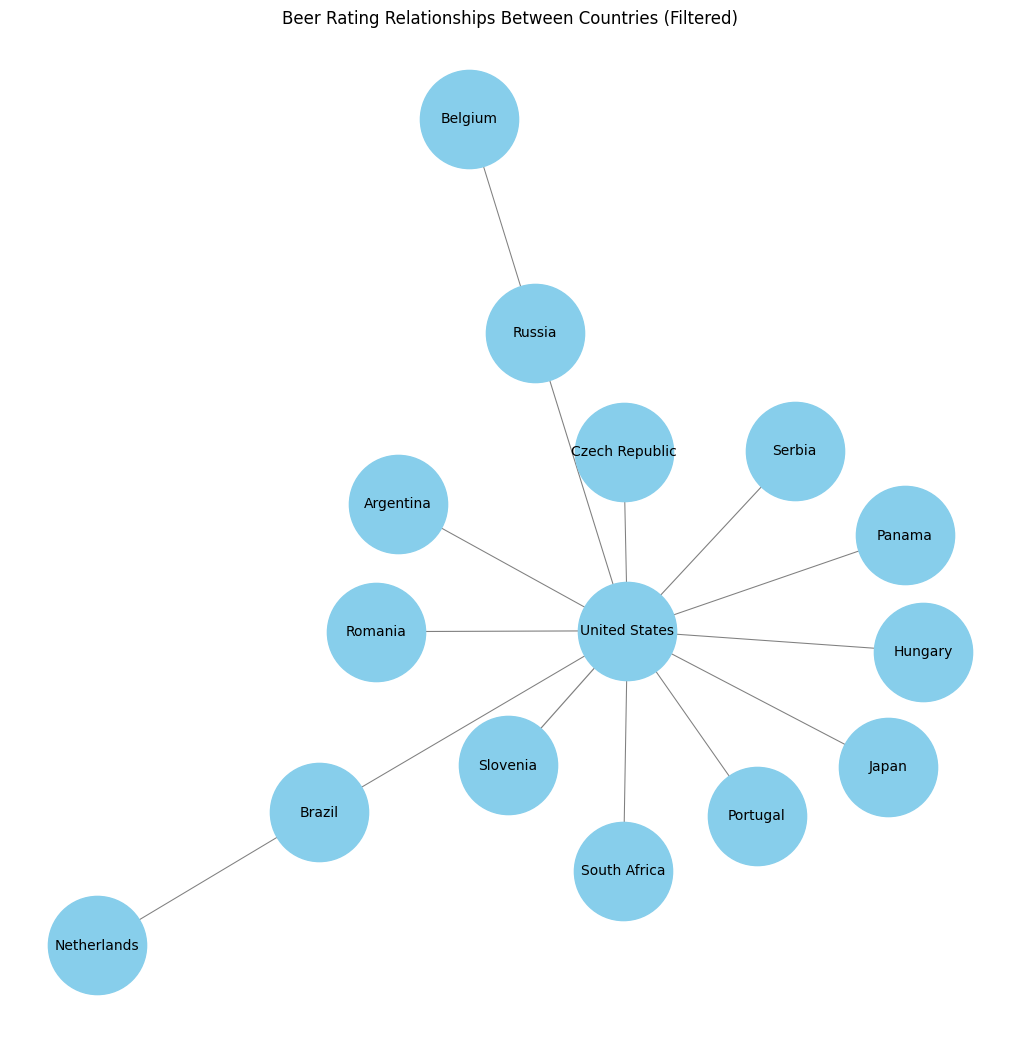

In [184]:
# Define a threshold for edge filtering based on average rating
threshold = 3.75  # Keep edges with an average rating above this value

# Filter edges by the threshold
filtered_edges = [(u, v) for u, v, d in G_filtered.edges(data=True) if d['weight'] > threshold]

# Create a filtered subgraph
filtered_graph = G_filtered.edge_subgraph(filtered_edges).copy()

# Visualization of the filtered graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(filtered_graph, k=0.1, iterations=100)
edges = filtered_graph.edges(data=True)
nx.draw(filtered_graph, pos, with_labels=True, node_color='skyblue', node_size=5000, edge_color='gray', width=[(d['weight']/5) for u, v, d in edges], font_size=10)
plt.title("Beer Rating Relationships Between Countries (Filtered)")
plt.show()



The network graph, with a high threshold of 3.75 for average beer ratings, indicates that the United States is the predominant node due to the American-centric nature of the data sources. This suggests a significant skew towards U.S. beer ratings. The sparse connections between the U.S. and various countries suggest selective international appreciation for quality beers. Few inter-country connections outside the U.S. imply isolated pockets of mutual beer enthusiasm rather than a widespread 'Beer Union'.

# Is there a domestic beer pride? Do users rate beers brewed in their home country better or worse?

In [126]:
# Filter out rows where 'user_location' or 'brewery_location' is 'nan' and create a copy
ratings_filtered = ratings.loc[(ratings['user_location'] != 'nan') & (ratings['brewery_location'] != 'nan')].copy()

# Add a new column categorizing each rating as domestic or international
ratings_filtered['rating_category'] = ['domestic' if user_loc == brew_loc else 'international'
                                       for user_loc, brew_loc in zip(ratings_filtered['user_location'], ratings_filtered['brewery_location'])]

# Calculate average ratings for domestic and international beers
average_ratings = ratings_filtered.groupby('rating_category')['rating'].mean()

# Compare the average ratings
domestic_rating = average_ratings.get('domestic', 0)
international_rating = average_ratings.get('international', 0)

print(f"Average domestic rating: {domestic_rating}")
print(f"Average international rating: {international_rating}")


Average domestic rating: 3.5005157775187987
Average international rating: 3.487596159330097


But is this statistically significant?

In [130]:
# Separate the ratings into two groups: domestic and international
domestic_ratings = ratings_filtered[ratings_filtered['rating_category'] == 'domestic']['rating']
international_ratings = ratings_filtered[ratings_filtered['rating_category'] == 'international']['rating']

# Perform the t-test
t_test_result = stats.ttest_ind(domestic_ratings, international_ratings, equal_var=False)  # Welch's t-test
print(t_test_result)


TtestResult(statistic=12.016049263109084, pvalue=2.938881595047869e-33, df=1232863.4615793305)


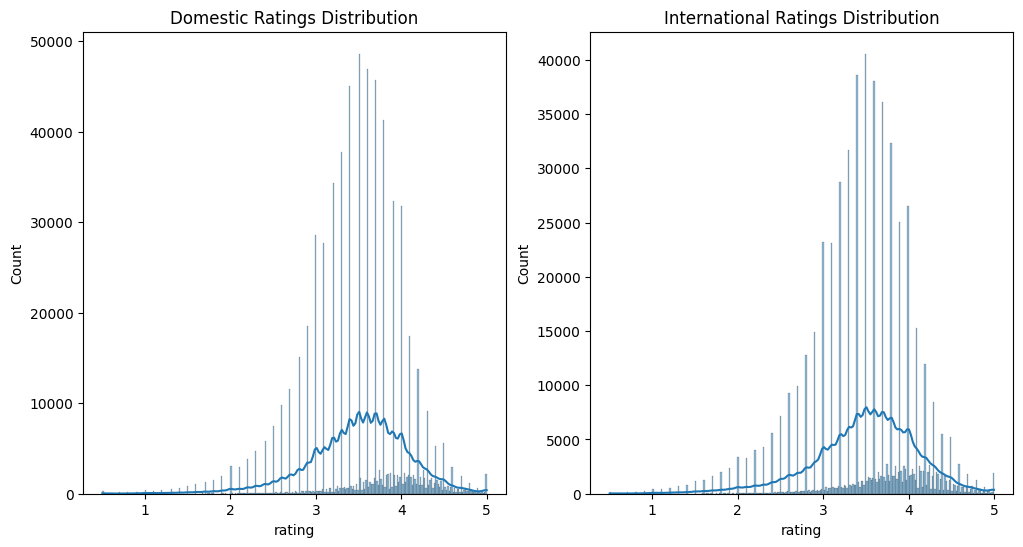

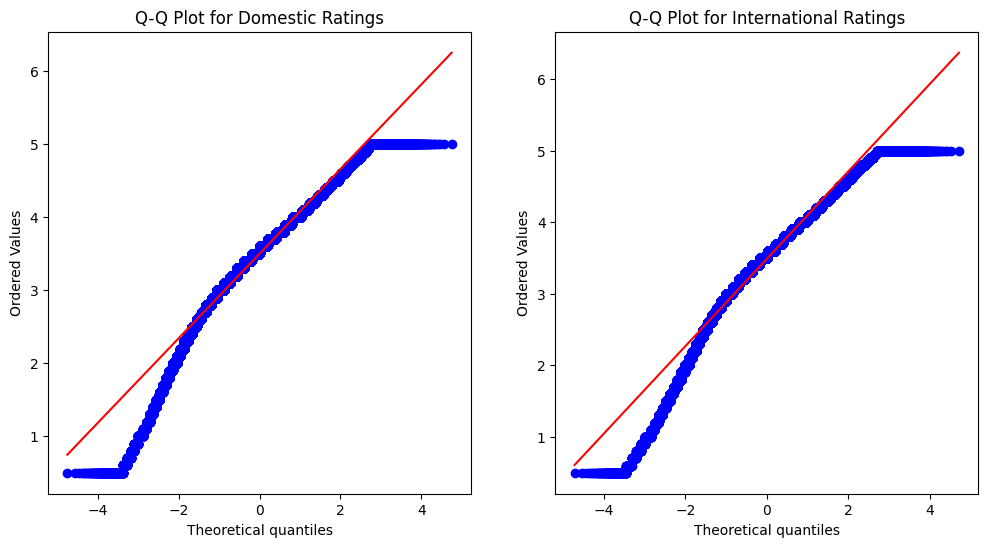

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for visual inspection of normality
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(domestic_ratings, kde=True)
plt.title('Domestic Ratings Distribution')

plt.subplot(1, 2, 2)
sns.histplot(international_ratings, kde=True)
plt.title('International Ratings Distribution')

plt.show()

# Q-Q Plots for normality check
import scipy.stats as stats

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(domestic_ratings, dist="norm", plot=plt)
plt.title('Q-Q Plot for Domestic Ratings')

plt.subplot(1, 2, 2)
stats.probplot(international_ratings, dist="norm", plot=plt)
plt.title('Q-Q Plot for International Ratings')

plt.show()


The data shows a preference for higher ratings in both domestic and international groups. The significant skewness and heavy tails should be taken into account when performing statistical tests.

Given the large sample size and the robustness of Welch's t-test to violations of the equal variance and normality assumptions, the conclusion of a difference in ratings is statistically sound.